In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rasterio

In [4]:
LABELS_DIR = "/fab3/btech/2022/snehanshu.pal22b/SolarPanel/labels/labels_native"
IMAGES_DIR = "/fab3/btech/2022/snehanshu.pal22b/SolarPanel/image_chips_native-20250212T103727Z-001/image_chips_native"


DEFAULT_METERS_PER_PIXEL = 0.31  

def get_meters_per_pixel(tiff_path):
    
    try:
        with rasterio.open(tiff_path) as src:
            transform = src.transform
            meters_per_pixel = abs(transform.a)  
            return meters_per_pixel
    except Exception as e:
        print(f"Could not read {tiff_path}: {e}")
        return DEFAULT_METERS_PER_PIXEL  

def match_labels_to_images():
   
    
    label_files = sorted([f for f in os.listdir(LABELS_DIR) if f.endswith(".txt")])
    image_files = sorted([f for f in os.listdir(IMAGES_DIR) if f.endswith(".tif")])
    
    
    label_map = {os.path.splitext(f)[0]: f for f in label_files}
    image_map = {os.path.splitext(f)[0]: f for f in image_files}

    
    matched_pairs = []
    for base_name in label_map:
        if base_name in image_map:  
            matched_pairs.append((label_map[base_name], image_map[base_name]))
            # print(f"Matched: {base_name}")

    return matched_pairs


In [5]:
def analyze_label_distribution(matched_pairs):
    
    label_counts = []
    
    
    for label_file, _ in matched_pairs:
        with open(os.path.join(LABELS_DIR, label_file), "r") as file:
            num_labels = len(file.readlines())
            label_counts.append(num_labels)
    
    
    min_labels = min(label_counts)
    max_labels = max(label_counts)
    
    
    distribution = {}
    for count in range(min_labels, max_labels + 1):
        num_images = label_counts.count(count)
        if num_images > 0:  
            distribution[count] = num_images
    
    
    df = pd.DataFrame.from_dict(distribution, orient='index', columns=['Number of Images'])
    df.index.name = 'Number of Labels'
    
    return df

def count_solar_panels(matched_pairs):
    """Counts total instances of solar panels and label distribution per image."""
    total_instances = 0
    label_counts = []

    for label_file, _ in matched_pairs:
        with open(os.path.join(LABELS_DIR, label_file), "r") as file:
            lines = file.readlines()
            count = sum(1 for line in lines if line.split()[0] == '0')  # Count only instances with class label 0
            total_instances += count
            label_counts.append(count)

    return total_instances, label_counts


In [6]:
matched_pairs = match_labels_to_images()

total_instances, label_counts = count_solar_panels(matched_pairs)

label_distribution = analyze_label_distribution(matched_pairs)

In [7]:
with open('Q1_results.txt', 'w') as f:
    
    f.write(f"Total number of solar panel instances: {total_instances}\n\n")
    
    
    f.write("Distribution of labels per image:\n")
    f.write("--------------------------------\n")
    f.write(label_distribution.to_string())

In [8]:
def compute_area_statistics(matched_pairs):
    """Computes area statistics for solar panels based on YOLO labels and images.
    Only considers objects with class label 0."""
    areas = []

    for label_file, image_file in matched_pairs:
        image_path = os.path.join(IMAGES_DIR, image_file)
        meters_per_pixel = get_meters_per_pixel(image_path)

        with open(os.path.join(LABELS_DIR, label_file), "r") as file:
            for line in file:
                parts = line.strip().split()
                class_label = int(parts[0])  # Extract class label
                
                # Only process objects with class label 0
                if class_label == 0:
                    _, _, _, width, height = map(float, parts)  # Extract YOLO bbox values
                    
                    # Convert from normalized YOLO format to meters
                    width_m = width * meters_per_pixel
                    height_m = height * meters_per_pixel
                    
                    area = width_m * height_m  # Compute area in square meters
                    areas.append(area)

    # Compute statistics
    mean_area = np.mean(areas) if areas else 0
    std_area = np.std(areas) if areas else 0

    return areas, mean_area, std_area

def plot_area_histogram(areas):
    """Plots the histogram of computed areas."""
    plt.figure(figsize=(8, 5))
    plt.hist(areas, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    plt.xlabel("Area (sq. meters)")
    plt.ylabel("Frequency")
    plt.title("Histogram of Solar Panel Areas")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    

/fab3/btech/2022/snehanshu.pal22b/anaconda3/envs/iitgn/lib/python3.8/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)



Mean Area: 0.01 sq. meters
Standard Deviation: 0.04 sq. meters


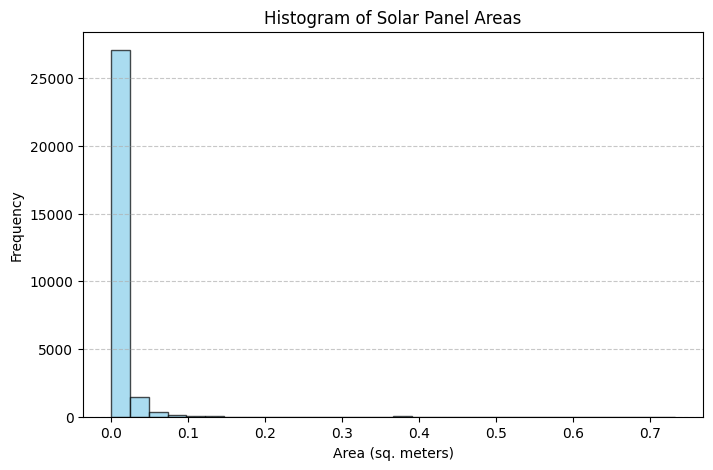

In [9]:
areas, mean_area, std_area = compute_area_statistics(matched_pairs)
print(f"\nMean Area: {mean_area:.2f} sq. meters")
print(f"Standard Deviation: {std_area:.2f} sq. meters")

# Plot histogram
plot_area_histogram(areas)

# Observations from the Histogram of Solar Panel Areas

- **Highly Skewed Distribution**: The histogram is heavily right-skewed, indicating that most solar panel areas are very small.  
- **Majority of Areas are Small**: A large number of data points fall within the smallest bin, suggesting that most panels in the dataset have very small surface areas.  
- **Few Large Panels**: There are very few instances of larger panel areas (above 0.1 square meters), as seen in the long right tail of the distribution.  
- **Possible Data Issues**: The extreme concentration near zero might indicate:
  - Measurement precision issues.
  - The dataset including many small or partial solar panel installations.
  - Potential data entry inconsistencies.

In [22]:
from shapely.geometry import box
from sklearn.metrics import auc
import random

In [27]:
def compute_iou(box1, box2):
    """Calculate the Intersection over Union (IoU) of two bounding boxes."""
    polygon1 = box(*box1)
    polygon2 = box(*box2)
    
    if not polygon1.intersects(polygon2):
        return 0.0
    
    intersection_area = polygon1.intersection(polygon2).area
    union_area = polygon1.union(polygon2).area
    
    return intersection_area / union_area

def pascal_voc_11_point_ap(recalls, precisions):
    """Compute AP using Pascal VOC 11 point interpolation method."""
    ap = 0.0
    for t in np.linspace(0, 1, 11):
        p = np.max(precisions[recalls >= t]) if np.sum(recalls >= t) != 0 else 0
        ap += p / 11.0
    return ap

def coco_101_point_ap(recalls, precisions):
    """Compute AP using COCO 101-point interpolation method."""
    ap = 0.0
    for t in np.linspace(0, 1, 101):
        p = np.max(precisions[recalls >= t]) if np.sum(recalls >= t) != 0 else 0
        ap += p / 101.0
    return ap

def auc_pr_ap(recalls, precisions):
    """Compute AP using Area under Precision-Recall Curve method."""
    return auc(recalls, precisions)

def compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5):
    """Compute precision and recall for given ground truth and predicted boxes."""
    tp = 0
    fp = 0
    fn = len(gt_boxes)
    
    for pred_box in pred_boxes:
        ious = [compute_iou(pred_box, gt_box) for gt_box in gt_boxes]
        if max(ious) >= iou_threshold:
            tp += 1
            fn -= 1
        else:
            fp += 1
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return precision, recall




In [28]:
def generate_random_boxes(image_size, box_size, num_boxes):
    """Generate random bounding boxes within the given image size."""
    boxes = []
    for _ in range(num_boxes):
        x_min = random.randint(0, image_size - box_size)
        y_min = random.randint(0, image_size - box_size)
        x_max = x_min + box_size
        y_max = y_min + box_size
        boxes.append((x_min, y_min, x_max, y_max))
    return boxes


In [29]:
image_size = 100
box_size = 20
num_images = 10
num_boxes = 10
iou_threshold = 0.5

precisions = []
recalls = []

for _ in range(num_images):
    gt_boxes = generate_random_boxes(image_size, box_size, num_boxes)
    pred_boxes = generate_random_boxes(image_size, box_size, num_boxes)
    
    precision, recall = compute_precision_recall(gt_boxes, pred_boxes, iou_threshold)
    precisions.append(precision)
    recalls.append(recall)

precisions = np.array(precisions)
recalls = np.array(recalls)

# Sort by recall
sorted_indices = np.argsort(recalls)
recalls = recalls[sorted_indices]
precisions = precisions[sorted_indices]

ap_voc = pascal_voc_11_point_ap(recalls, precisions)
ap_coco = coco_101_point_ap(recalls, precisions)
ap_auc = auc_pr_ap(recalls, precisions)

print(f"Pascal VOC 11-point AP: {ap_voc:.4f}")
print(f"COCO 101-point AP: {ap_coco:.4f}")
print(f"AUC-PR AP: {ap_auc:.4f}")

Pascal VOC 11-point AP: 0.0818
COCO 101-point AP: 0.0921
AUC-PR AP: 0.0450


In [10]:
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
import shutil

In [17]:
dataset_dir = os.path.abspath("yolo_dataset")  # Get absolute path
  # Directory to store YOLO formatted dataset

# Create YOLO dataset structure
for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(dataset_dir, 'images', split), exist_ok=True)
    os.makedirs(os.path.join(dataset_dir, 'labels', split), exist_ok=True)

# Get image and corresponding label files
image_files = [f for f in os.listdir(IMAGES_DIR) if f.endswith('.tif')]

def filter_labels(label_path, output_path):
    """Filter labels to keep only class 0 and write to new file"""
    filtered_lines = []
    try:
        with open(label_path, 'r') as file:
            for line in file:
                parts = line.split()
                if int(parts[0]) == 0:  # Keep only class 0 labels
                    filtered_lines.append(line)
        # Write filtered labels to new file
        with open(output_path, 'w') as file:
            file.writelines(filtered_lines)
        return len(filtered_lines) > 0  # Return True if file has valid labels
    except:
        return False

# Collect data pairs and filter labels
data = []
for img in image_files:
    label_file = os.path.splitext(img)[0] + ".txt"
    if label_file in os.listdir(LABELS_DIR):
        src_label_path = os.path.join(LABELS_DIR, label_file)
        # Create filtered label in temporary location
        temp_label_path = os.path.join(dataset_dir, 'temp_labels', label_file)
        os.makedirs(os.path.join(dataset_dir, 'temp_labels'), exist_ok=True)
        
        if filter_labels(src_label_path, temp_label_path):
            data.append((img, label_file))

print(f"Total images with class 0 labels: {len(data)}")

# Split dataset into train (80%) and test (20%)
train_data, test_data = train_test_split(data, test_size=0.2)
# Further split train data into train (90%) and val (10%)
train_data, val_data = train_test_split(train_data, test_size=0.1)

# Modified move_files function to use filtered labels
def move_files(data_split, split_name):
    for img, label in data_split:
        # Copy image
        shutil.copy(os.path.join(IMAGES_DIR, img), 
                   os.path.join(dataset_dir, 'images', split_name, img))
        # Copy filtered label
        shutil.copy(os.path.join(dataset_dir, 'temp_labels', label),
                   os.path.join(dataset_dir, 'labels', split_name, label))

move_files(train_data, 'train')
move_files(val_data, 'val')
move_files(test_data, 'test')

# Clean up temporary labels
shutil.rmtree(os.path.join(dataset_dir, 'temp_labels'))

# Create YOLOv8 data configuration file
data_yaml = f"""
nc: 1
names: ["solar_panel"]
download: ""
train: {os.path.join(dataset_dir, 'images', 'train')}
val: {os.path.join(dataset_dir, 'images', 'val')}
test: {os.path.join(dataset_dir, 'images', 'test')}
"""

with open(os.path.join(dataset_dir, "data.yaml"), "w") as f:
    f.write(data_yaml)

Total images with class 0 labels: 2528


In [18]:
print(os.path.exists(os.path.join(dataset_dir, "data.yaml")))  # Should print True


True


In [19]:
model = YOLO("yolov8s.pt")  # Using YOLOv8 small model
model.train(data=os.path.join(dataset_dir, "data.yaml"), epochs=20, imgsz=416, device="5")
  # Training on GPU 0


New https://pypi.org/project/ultralytics/8.3.80 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.75 🚀 Python-3.8.20 torch-2.4.1+cu121 CUDA:5 (Tesla V100-PCIE-32GB, 32501MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=5, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_

train: Scanning /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/labels/train... 2522 images, 0 backgrounds, 14 corrupt: 100%|██████████| 2522/2522 [00:05<00:00, 429.67it/s]

train: WARNING ⚠️ /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/train/solarpanels_native_1__x0_8565_y0_11093_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/train/solarpanels_native_1__x0_8573_y0_11090_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/train/solarpanels_native_1__x0_8582_y0_11150_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNING ⚠️ /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/train/solarpanels_native_1__x0_8596_y0_11097_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
train: WARNI

train: New cache created: /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/labels/train.cache


val: Scanning /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/labels/val... 716 images, 0 backgrounds, 16 corrupt: 100%|██████████| 716/716 [00:02<00:00, 301.63it/s]

val: WARNING ⚠️ /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/val/solarpanels_native_1__x0_2309_y0_8071_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/val/solarpanels_native_1__x0_8239_y0_7742_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/val/solarpanels_native_1__x0_8326_y0_8594_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /fab3/btech/2022/snehanshu.pal22b/SolarPanel/yolo_dataset/images/val/solarpanels_native_1__x0_8350_y0_8860_dxdy_416.tif: ignoring corrupt image/label: Label class 2 exceeds dataset class count 1. Possible class labels are 0-0
val: WARNING ⚠️ /fab3/btech/2022

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      3.67G      1.622       1.52      1.243        255        416:  85%|████████▍ | 133/157 [01:15<00:13,  1.75it/s]


KeyboardInterrupt: 